In [44]:
import os
import glob
import zipfile
import tempfile
import requests
import traceback
from typing import Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cluttercal

In [18]:
def download_radar_data(rid: Any, date: pd.Timestamp, zip_path: str ="/tmp/") -> str:
    """
    Download data from the long-term archive of the Australian Bureau of 
    Meteorology operational weather radar network. 

    Parameters:
    ===========
    rid: int
        Australian archive radar ID (an integer from 1 to ~107). e.g. Melbourne 
        is 2, Sydney is 71, etc.
    date: pd.Timestamp
        Day we want to download.
    zip_path: str
        Path where to save the zipfile.
    
    Returns:
    ========
    zipname: str
        Filename of the downloaded data
    """
    year = date.year
    datestr = date.strftime("%Y%m%d")
    url = f"https://dapds00.nci.org.au/thredds/fileServer/rq0/{rid}/{year}/vol/{rid}_{datestr}.pvol.zip"
    zipname = os.path.join(zip_path, os.path.basename(url))

    r = requests.get(url)
    with open(zipname, "wb") as fid:
        fid.write(r.content)

    return zipname

In [45]:
def extract_clutter(infile: str, cmask: np.ndarray) -> Tuple[pd.Timestamp, float]:
    """
    Buffer function to catch and kill errors about missing Sun hit.
    Parameters:
    ===========
    infile: str
        Input radar file.
    cmask: np.ndarray <azimuth, range> (360 x 20)
        Clutter mask generated by cluttercal.

    Returns:
    ========
    dtime: np.datetime64
        Datetime of infile
    rca: float
        95th percentile of the clutter reflectivity.
    """
    try:
        dtime, rca = cluttercal.extract_clutter(infile, cmask, refl_name="TH")
    except ValueError:
        return None
    except Exception:
        print(infile)
        traceback.print_exc()
        return None

    return dtime, rca

In [20]:
rid = 95
date = pd.Timestamp("2023-02-01")
datestr = date.strftime("%Y%m%d")

outpath_cmask = "./cmask"
os.makedirs(outpath_cmask, exist_ok=True)
outputfile_cmask = os.path.join(outpath_cmask, f"{rid}_{datestr}.nc")
outpath_rca = "./RCA"
os.makedirs(outpath_rca, exist_ok=True)

In [22]:
zipname = download_radar_data(rid, date)

In [24]:
with tempfile.TemporaryDirectory() as temp_dir:    
    # Extract the ZIP file into the temporary directory
    with zipfile.ZipFile(zipname, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
        flist = glob.glob(os.path.join(temp_dir, "*.*"))
    
    cmask = cluttercal.clutter_mask(flist, output=outputfile_cmask, refl_name="TH", refl_threshold=40, use_dask=True)
    # Generate composite clutter mask.
    try:
        cmask = cluttercal.composite_mask(date, timedelta=7, indir=outpath_cmask, prefix=f"{rid}_")
    except ValueError:
        # single mask
        cmask = cluttercal.single_mask(outputfile_cmask)

    arglist = [(f, cmask) for f in flist]
    with ProgressBar()
        bag = db.from_sequence(arglist).starmap(extract_clutter)
        rslt = [r for r in bag.compute() if r is not None]



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/matp


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vlouf/miniconda3/envs/radar/lib/python3.10/site-packages/matplotlib/__init__.py:15

Clutter mask ./cmask/95_20230201.nc created.


/tmp/ipykernel_96054/3316410485.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, cmask)


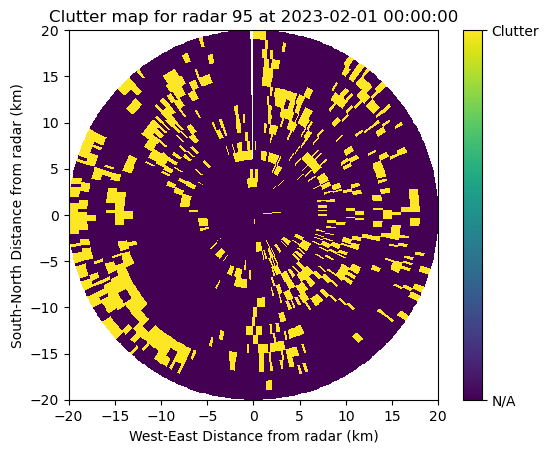

In [43]:
azi = np.arange(0, 360)
theta = np.deg2rad((450 - azi) % 360)
r = np.arange(0, 21)
R, T = np.meshgrid(r, theta)
x = R * np.cos(T)
y = R * np.sin(T)

fig = plt.figure()
plt.pcolormesh(x, y, cmask)
plt.gca().set_aspect(1)
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["N/A", "Clutter"])
plt.title(f"Clutter map for radar {rid} at {date}")
plt.xlabel("West-East Distance from radar (km)")
plt.ylabel("South-North Distance from radar (km)")
plt.show()

In [ ]:
extract_clutter()